# PROJECT TITLE

Myntra Website Data Scraping and Analysis using Selenium

# BUSINESS PROBLEM

Myntra’s product data is available only in unstructured web formats, making it difficult for businesses to analyze pricing, brand performance, and customer demand. This lack of structured data limits data-driven decision-making and competitive analysis.

# PROBLEM STATEMENT

Developed a Selenium-based web scraping system to extract around 2000 product listings from Myntra, followed by data cleaning, exploratory data analysis, and hypothesis testing to identify pricing trends, customer preferences and brand performance in the e-commerce fashion domain.

# OBJECTIVE

To automate the extraction of product data from the Myntra e-commerce platform using Selenium and perform exploratory data analysis to uncover pricing, brand insights.

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time


options = webdriver.ChromeOptions()
options.add_argument("--start-maximized")

driver = webdriver.Chrome(
    service=Service(ChromeDriverManager().install()),
    options=options
)

BASE_URL = "https://www.myntra.com/men-tshirts?p={}"
products = []
seen = set()


for page in range(1, 100):  
    print(f"Scraping page {page}")
    driver.get(BASE_URL.format(page))
    time.sleep(3)


    for _ in range(3):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)

    items = driver.find_elements(By.CLASS_NAME, "product-base")

    if not items:
        print("No items found, stopping.")
        break

    for item in items:
        try:
            brand = item.find_element(By.CLASS_NAME, "product-brand").text
            name = item.find_element(By.CLASS_NAME, "product-product").text
            price = item.find_element(By.CLASS_NAME, "product-discountedPrice").text
        except:
            try:
                price = item.find_element(By.CLASS_NAME, "product-price").text
            except:
                price = None

        try:
            rating = item.find_element(By.CLASS_NAME, "product-ratingsContainer").text
        except:
            rating = None

        key = (brand, name)
        if key in seen:
            continue
        seen.add(key)

        products.append({
            "Brand": brand,
            "Product": name,
            "Price": price,
            "Rating": rating
        })

    print("Total products scraped:", len(products))

    if len(products) >= 2000:
        break


df = pd.DataFrame(products)
df.to_csv("C:/Users/VARSHA SURA/OneDrive/Desktop/EDA Project/data/myntra_products.csv", index=False)

driver.quit()

print("Final records:", len(df))


In [1]:
import pandas as pd
df=pd.read_csv(r"C:/Users/VARSHA SURA/OneDrive/Desktop/EDA Project/data/myntra_products.csv")

In [2]:
df

,Brand,Product,Price,Rating
0,CULT,Move All Day Fly Dry T-shirt,Rs. 659,4.4\n|\n1.1k
1,Jack & Jones,Slim Fit Pure Cotton T-shirt,Rs. 714,4.1\n|\n163
2,Levis,Solid Lounge T-shirt,Rs. 473,4.4\n|\n18.1k
3,BROWN BROTHERS,Unisex Cotton Casual T-shirt,Rs. 471,4.3\n|\n409
4,Maniac,Men Solid Slim Fit T-shirt,Rs. 999,4.2\n|\n511
...,...,...,...,...
1706,HERE&NOW,Open-Knits Cotton T-shirt,Rs. 549,4.2\n|\n39
1707,BDSQUARE,Printed Round Neck T-shirt,Rs. 399,4.1\n|\n37
1708,FTX,Men Pack of 4 Solid T-shirts,Rs. 469,4.2\n|\n17
1709,CULT,Men's Black Training T-shirt,Rs. 459,4.5\n|\n43


## Data cleaning

In [3]:
df['Price'] = df['Price'].str.replace('Rs. ','').astype(float)
df['Rating_Value'] = df['Rating'].str.split('|').str[0].astype(float)
df['Rating_Count'] = df['Rating'].str.split('|').str[1].str.replace('k','000').astype(float)
df.drop('Rating', axis=1, inplace=True)
df.head()

,Brand,Product,Price,Rating_Value,Rating_Count
0,CULT,Move All Day Fly Dry T-shirt,659.0,4.4,1.1
1,Jack & Jones,Slim Fit Pure Cotton T-shirt,714.0,4.1,163.0
2,Levis,Solid Lounge T-shirt,473.0,4.4,18.1
3,BROWN BROTHERS,Unisex Cotton Casual T-shirt,471.0,4.3,409.0
4,Maniac,Men Solid Slim Fit T-shirt,999.0,4.2,511.0


In [4]:
df.isnull().sum()

Brand             0
Product           0
Price             0
Rating_Value    201
Rating_Count    201
dtype: int64

In [5]:

df['Rating_Value'] = df['Rating_Value'].fillna(df['Rating_Value'].median())
df['Rating_Count'] = df['Rating_Count'].fillna(df['Rating_Count'].median())


In [6]:
df.isnull().sum()

Brand           0
Product         0
Price           0
Rating_Value    0
Rating_Count    0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
numeric_cols = ['Price', 'Rating_Value', 'Rating_Count']
outliers_iqr = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_iqr[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col].count()

print("Number of outliers (IQR method):")
print(outliers_iqr)


Number of outliers (IQR method):
{'Price': np.int64(18), 'Rating_Value': np.int64(102), 'Rating_Count': np.int64(238)}


## 1. How many unique brands are present?

In [9]:
num_brands = df['Brand'].nunique()
print(num_brands)

230


There are total 230 unique brands are there

## 2. What is the price distribution of all products?

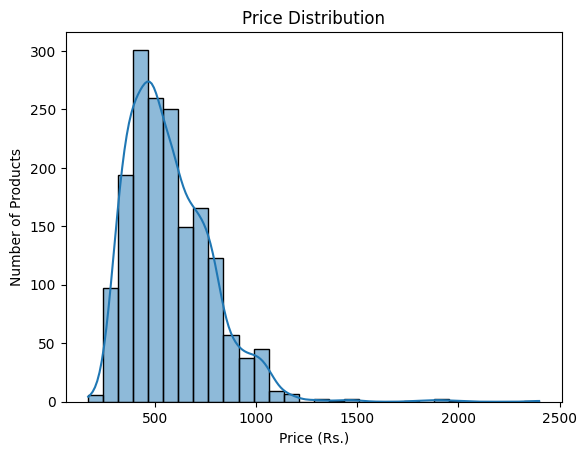

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['Price'], bins=30, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (Rs.)")
plt.ylabel("Number of Products")
plt.show()


Most products are priced between 200 and 800 Rs.

The curve has a long tail to the right, meaning a few products are very expensive (up to nearly 2400 Rs.).

## 3. What is the total number of products in the dataset?

In [11]:
num_products = df.shape[0]
print("Total products are", num_products)


Total products are 1711


## 4. What is the distribution of product ratings?

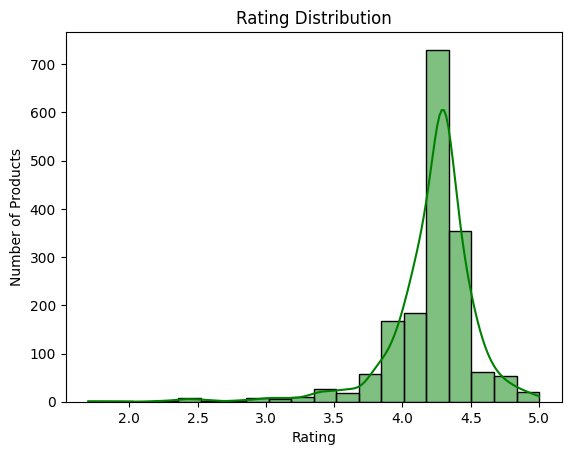

In [12]:
sns.histplot(df['Rating_Value'], bins=20, kde=True, color='green')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Products")
plt.show()


The distribution is left-skewed and most ratings are high, between 4.0 and 4.5.

## 5. Which brands have the most products?

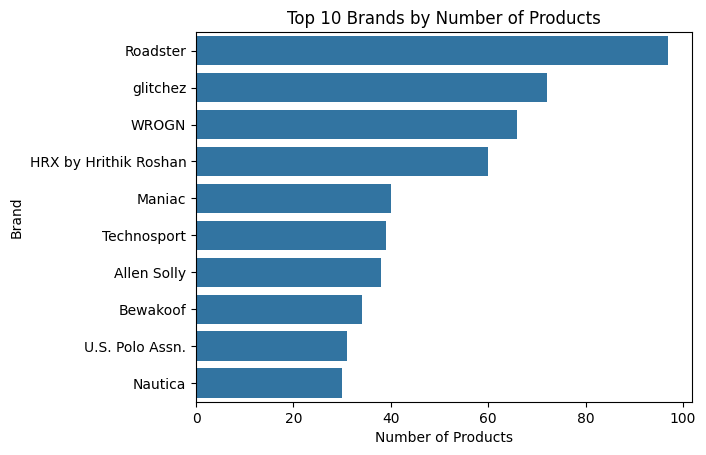

In [13]:
top_brands = df['Brand'].value_counts().head(10)
sns.barplot(x=top_brands.values, y=top_brands.index)
plt.title("Top 10 Brands by Number of Products")
plt.xlabel("Number of Products")
plt.ylabel("Brand")
plt.show()


Roadster leads with the highest number of products (~97), showing strong presence and variety on the platform.

## 6. What is the average price per brand?

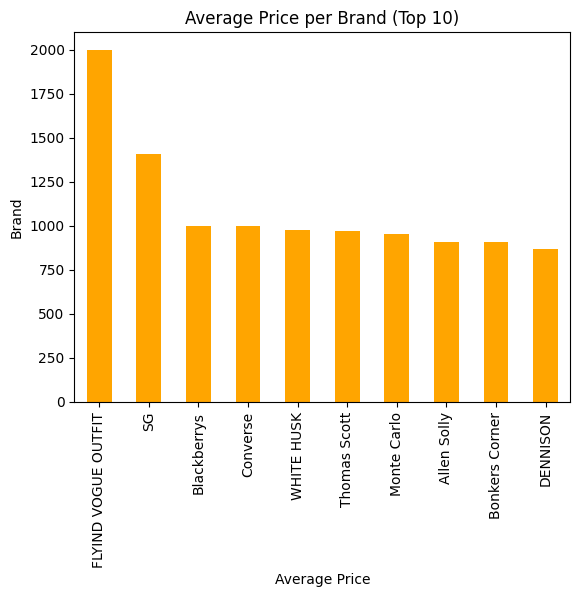

In [14]:
avg_price_brand = df.groupby('Brand')['Price'].mean().sort_values(ascending=False).head(10)
avg_price_brand.plot(kind='bar', color='orange', title='Average Price per Brand (Top 10)')
plt.xlabel("Average Price")
plt.ylabel("Brand")
plt.show()


FLYING VOGUE OUTFIT is the most expensive brand on average, around ₹2000.

This indicates it targets premium customers or higher-end fashion.

## 7. Which brands have the highest average ratings?

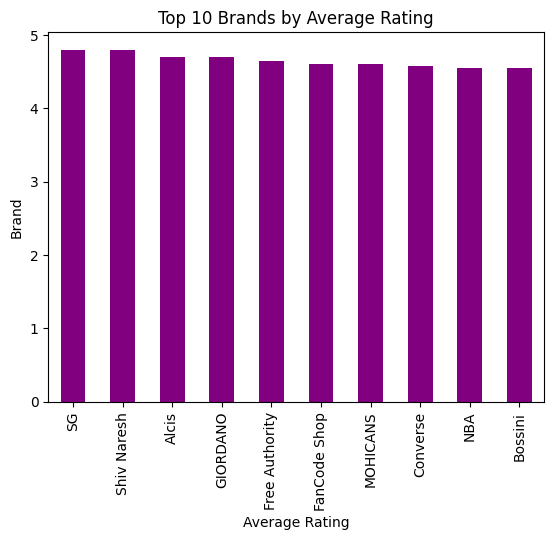

In [15]:
avg_rating_brand = df.groupby('Brand')['Rating_Value'].mean().sort_values(ascending=False).head(10)
avg_rating_brand.plot(kind='bar', color='purple', title='Top 10 Brands by Average Rating')
plt.xlabel("Average Rating")
plt.ylabel("Brand")
plt.show()


All the top 10 brands have average ratings close to 4.5–4.8, indicating that customers generally rate these brands highly.

## 8. Which products have the highest number of ratings ?

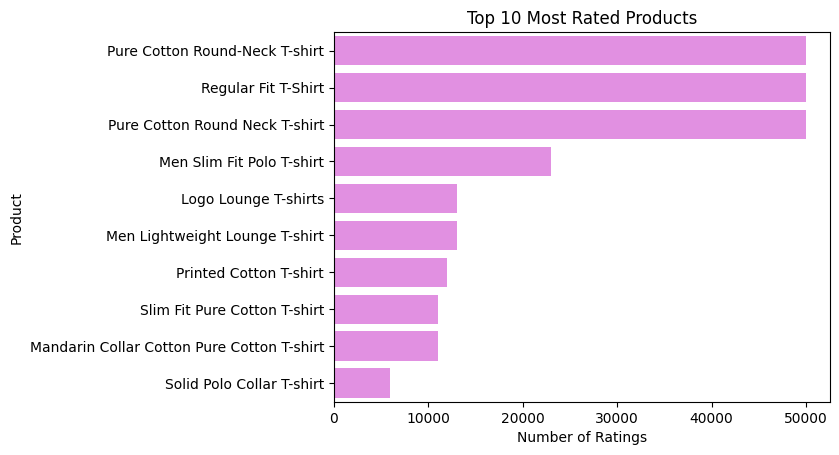

In [16]:
top_rated_products = df.sort_values('Rating_Count', ascending=False).head(10)
sns.barplot(x=top_rated_products['Rating_Count'], y=top_rated_products['Product'],color='violet')
plt.title("Top 10 Most Rated Products")
plt.xlabel("Number of Ratings")
plt.ylabel("Product")
plt.show()


Pure Cotton Round-Neck T-shirt, Regular Fit T- shirt, Pure Cotton Round Neck Tshirt having more number of ratings

## 9. Do premium-priced products have higher ratings than budget products?

H0: There is no difference in ratings between premium and budget products.

H1: Premium products have higher ratings.


In [17]:
import scipy.stats as stats


premium = df[df['Price'] > df['Price'].median()]['Rating_Value']
budget = df[df['Price'] <= df['Price'].median()]['Rating_Value']

t_stat, p_val = stats.ttest_ind(premium, budget, equal_var=False)
print("T-statistic:", t_stat)
print("P-value:", p_val)


T-statistic: 6.712652790969357
P-value: 2.604836625794594e-11


premium-priced products have significantly higher ratings than budget products

## 10. Does the number of ratings correlate with the product price?

H0: There is no correlation between price and number of ratings.

H1: There is a significant correlation.

In [18]:
corr, p_val = stats.pearsonr(df['Price'], df['Rating_Count'])
print("Correlation coefficient:", corr)
print("P-value:", p_val)


Correlation coefficient: -0.03289169491728786
P-value: 0.17385730859360185


Fail to reject the null hypothesis, There is no significant linear correlation between product price and the number of ratings. 

## 11. High-rated but less popular products

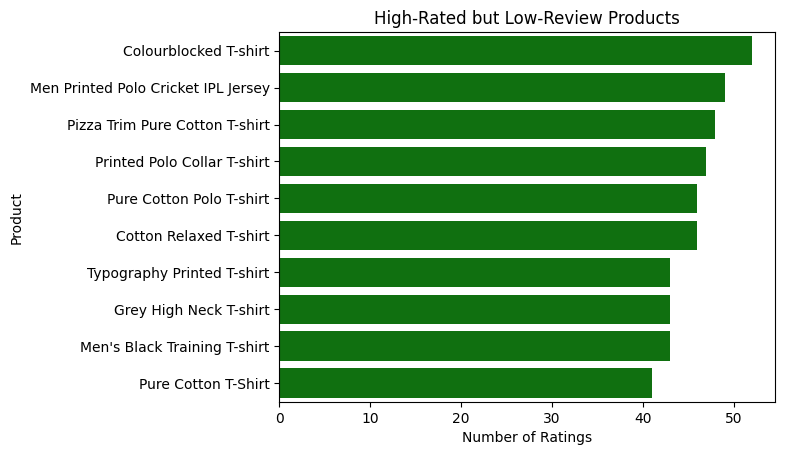

In [19]:
high_rating_low_reviews = df[(df['Rating_Value'] >= 4.5) & (df['Rating_Count'] < df['Rating_Count'].median())]
top_hidden_gems = high_rating_low_reviews.sort_values('Rating_Count', ascending=False).head(10)
sns.barplot(x=top_hidden_gems['Rating_Count'], y=top_hidden_gems['Product'], color='green')
plt.title("High-Rated but Low-Review Products")
plt.xlabel("Number of Ratings")
plt.ylabel("Product")
plt.show()



Colorblocked T-shirt having having high rating 5 but low review products

## 12 . What is Market Volume Share

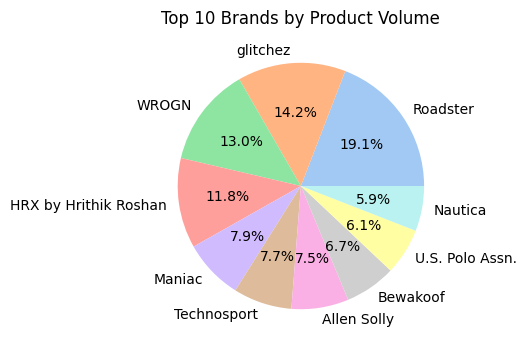

In [20]:
plt.figure(figsize=(4,4))
brand_counts = df['Brand'].value_counts().head(10) # Top 10
plt.pie(brand_counts, labels=brand_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Top 10 Brands by Product Volume')
plt.savefig('brand_market_share.png')

Roadster having more products

## 13. Finding high-quality budget items

In [21]:
value_kings = df[(df['Rating_Value'] >= 4.5) & (df['Price'] < df['Price'].median())]
print(value_kings[['Brand', 'Product', 'Price', 'Rating_Value']].head())

                    Brand                        Product  Price  Rating_Value
20              Crazymonk       Unisex Oversized T-shirt  497.0           4.5
30             Pepe Jeans        Crew Neck Lounge Tshirt  479.0           4.5
36                   CULT    Shoulder Pop Active T-shirt  371.0           4.5
52  HRX by Hrithik Roshan     Rapid-Dry Training T-shirt  368.0           4.5
78                 NOBERO  Oversized Pure Cotton T-shirt  499.0           4.5


These are five product with high quality and budget items

## 14. Is there an association between Price Range and Rating Category

In [24]:
df['Rating_Category'] = pd.cut(
    df['Rating_Value'],
    bins=[0, 3.5, 4.0, 5.0],
    labels=['Low', 'Medium', 'High']
)

In [25]:
df['Price_Category'] = pd.cut(
    df['Price'],
    bins=[0, 500, 800, 1500],
    labels=['Low', 'Medium', 'High']
)


In [27]:
from scipy.stats import chi2_contingency

In [28]:
price_rating_table = pd.crosstab(df['Price_Category'], df['Rating_Category'])
chi2, p, dof, expected = chi2_contingency(price_rating_table)

print("p-value:", p)


p-value: 1.3761656243528744e-06
